In [1]:
import numpy as np
import pandas as pd
import sys
import re
import time
import datetime
from time import time, gmtime, strftime
from datetime import datetime
import statistics
from tqdm import tqdm_notebook as tqdm
from __future__ import division
from collections import Counter
from gensim import models
import gensim, logging
from gensim.models import Word2Vec
import pickle
import seaborn as sns
from copy import deepcopy

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, LeavePOut
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, LogisticRegressionCV, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc, mutual_info_score, average_precision_score, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize as tokenizer
import jellyfish
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell # no need of print for several objects!!!
InteractiveShell.ast_node_interactivity = "all"

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

%matplotlib inline

init_vec = True

Using TensorFlow backend.


2 possibilities:
- Load and merge samples and labels.
- Load pre-built dataset.

(go to either of them with Ctrl+F)

#### Load and merge samples and labels.

In [2]:
path = '/media/hdd/salaun/wikiedit/annotations/data_v1/'

file_list = ['00_09_42',
             '00_09_73',
             '10_19_42',
             '20_24_42',
             '25_29_42',
             '30_34_42',
             '35_39_42',
             '40_44_42_uniq_parag',
             '40_44_42',
             '40_44_73',
             '45_49_42',
             '45_49_73',
             '50_54_42',
             '50_54_73',
             '55_59_42',
             '55_59_73',
             '60_65_42',
             '66-69_72_42',
             '66-69_72_73'
              ]

df_sample = pd.concat([pd.read_csv(path + file + '_sample.tsv', sep="\t") for file in file_list], ignore_index=True)
df_post_annot = pd.concat([pd.read_csv(path + file + '_post_annot_S.csv', sep=';', header=None) for file in file_list], ignore_index=True)
df_post_annot.columns = ['index', 'sample_id', 'raw_annot']

print('Number of files:', len(file_list))
df_sample.shape
df_post_annot.shape

Number of files: 19


(1900, 35)

(1900, 3)

In [3]:
# get dummies
print('Length df_sample:', len(df_sample))
print('Length df_post_annot:', len(df_post_annot))

labels_lists = ['ortho_gram_typo','wiki_formatting', 'vandal', 'reordering', 
              'revert_vandal', 'revert_other', 'content_remove', 'content_add',
              'nbr_wr', 'nbr_rw', 'nbr_x', 
              'semant_simil', 'semant_diff', 
              'other']

gross_labels_list = ['semant', 'nbr', 'semant_or_nbr']

for label in labels_lists:
    df_post_annot[label] = df_post_annot.raw_annot.str.contains(label)


for label in gross_labels_list: #initialization
    df_post_annot[label] = False


for i in range(0, df_post_annot.shape[0]):
    
    if df_post_annot.semant_simil.iloc[i] or df_post_annot.semant_diff.iloc[i]:
        df_post_annot.loc[i,'semant'] = True

    if df_post_annot.nbr_wr.iloc[i] or df_post_annot.nbr_rw.iloc[i] or df_post_annot.nbr_x.iloc[i]:
        df_post_annot.loc[i,'nbr'] = True

    if df_post_annot.semant.iloc[i]==True or df_post_annot.nbr.iloc[i]==True:
        df_post_annot.loc[i,'semant_or_nbr'] = True

df_sample.shape
df_post_annot.shape

Length df_sample: 1900
Length df_post_annot: 1900


(1900, 35)

(1900, 20)

In [4]:
print("DISTRIBUTION OF LABELS OVER ALL ANNOTATIONS \n")

df_annot_distrib = pd.DataFrame(index=labels_lists, columns=['absolute number', 'share of all observations'])
df_annot_distrib_bis = pd.DataFrame(index=gross_labels_list, columns=['absolute number', 'share of all observations'])

for label in labels_lists:
    df_annot_distrib.loc[label,'absolute number'] = (df_post_annot[label]==1).sum()
    df_annot_distrib.loc[label,'share of all observations'] = 100*((df_post_annot[label]==1).sum())/len(df_post_annot)
df_annot_distrib 
    
for label in gross_labels_list:
    df_annot_distrib_bis.loc[label,'absolute number'] = (df_post_annot[label]==1).sum()
    df_annot_distrib_bis.loc[label,'share of all observations'] = 100*((df_post_annot[label]==1).sum())/len(df_post_annot)
df_annot_distrib_bis   

DISTRIBUTION OF LABELS OVER ALL ANNOTATIONS 



,absolute number,share of all observations
ortho_gram_typo,506,26.6316
wiki_formatting,696,36.6316
vandal,114,6
reordering,91,4.78947
revert_vandal,12,0.631579
revert_other,6,0.315789
content_remove,116,6.10526
content_add,477,25.1053
nbr_wr,39,2.05263
nbr_rw,7,0.368421


,absolute number,share of all observations
semant,355,18.6842
nbr,48,2.52632
semant_or_nbr,403,21.2105


In [5]:
df_XY = pd.concat([df_sample, df_post_annot.loc[:,'raw_annot':'semant_or_nbr']], axis=1)
df_XY.shape
df_XY.columns
df_XY = df_XY.fillna('')
df_XY.tail(2)

(1900, 53)

Index(['Unnamed: 0', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'modif', 'modif_add', 'modif_remove', 'parentid', 'registered',
       'sample_id', 'timestamp', 'title', 'user_id', 'username', 'raw_annot',
       'ortho_gram_typo', 'wiki_formatting', 'vandal', 'reordering',
       'revert_vandal', 'revert_other', 'content_remove', 'content_add',
       'nbr_wr', 'nbr_rw', 'nbr_x', 'semant_simil', 'semant_diff', 'other',
       'semant', 'nbr', 'semant_or_nbr'],
      dtype='object')

,Unnamed: 0,comment,filt_bot,filt_coher,filt_confli,filt_contradic,filt_erreur,filt_erron,filt_faux,filt_frappe,filt_gramma,filt_ortho,filt_revert,filt_sens,filt_tromp,filt_typo,filt_vandalisme,filt_vraise,format,id,id_file,id_modif,label_incoherence,minor,model,modif,modif_add,modif_remove,parentid,registered,sample_id,timestamp,title,user_id,username,raw_annot,ortho_gram_typo,wiki_formatting,vandal,reordering,revert_vandal,revert_other,content_remove,content_add,nbr_wr,nbr_rw,nbr_x,semant_simil,semant_diff,other,semant,nbr,semant_or_nbr
1898,98,,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,95886840,p5847438p6039053,1279779,False,False,wikitext,"- '''Michael Loewe''', de son vrai nom Mihai L...","'''Michael Loewe''', de son vrai nom Mihai Leu...","'''Michael Loewe''', de son vrai nom Mihai Leu...",95886829.0,True,p5847438p6039053_1279779,2013-08-17T21:34:39Z,Michael Loewe,31767,Skblzz1,ortho_gram_typo,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1899,99,/* Synopsis */,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,74105978,p5847438p6039053,1046153,False,False,wikitext,- Un homme et deux femmes se mettent à table. ...,Un homme et deux femmes se mettent à table. Au...,Un homme et deux femmes se mettent à table. Au...,74105972.0,True,p5847438p6039053_1046153,2012-01-09T02:18:33Z,Le Repas fantastique,418936,Celette,ortho_gram_typo,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


#### Load pre-built dataset.

In [6]:
#df_XY.to_csv(path + 'full_dataset_with_all_labels.tsv', sep='\t')

In [7]:
path = '/media/hdd/salaun/wikiedit/annotations/data_v1/'
df_XY = pd.read_csv(path + 'full_dataset_with_all_labels.tsv', sep='\t')
df_XY.columns
df_XY = df_XY.loc[:,'comment':'semant_or_nbr']
df_XY.shape

Index(['Unnamed: 0', 'Unnamed: 0.1', 'comment', 'filt_bot', 'filt_coher',
       'filt_confli', 'filt_contradic', 'filt_erreur', 'filt_erron',
       'filt_faux', 'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert',
       'filt_sens', 'filt_tromp', 'filt_typo', 'filt_vandalisme',
       'filt_vraise', 'format', 'id', 'id_file', 'id_modif',
       'label_incoherence', 'minor', 'model', 'modif', 'modif_add',
       'modif_remove', 'parentid', 'registered', 'sample_id', 'timestamp',
       'title', 'user_id', 'username', 'raw_annot', 'ortho_gram_typo',
       'wiki_formatting', 'vandal', 'reordering', 'revert_vandal',
       'revert_other', 'content_remove', 'content_add', 'nbr_wr', 'nbr_rw',
       'nbr_x', 'semant_simil', 'semant_diff', 'other', 'semant', 'nbr',
       'semant_or_nbr'],
      dtype='object')

(1900, 52)

#### Merge samples and labels.

Concentrate **"incoherent"** samples that are the strings in ***modif_remove*** in pairs labeled as ***semant_diff***

In [8]:
df_incoher = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'modif_remove',
       'parentid', 'registered',
       'sample_id', 'timestamp', 'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_diff].copy()
df_incoher = df_incoher.reset_index()
df_incoher = df_incoher.rename(columns = {'modif_remove':'string'})
df_incoher = pd.concat([df_incoher, pd.DataFrame({'incoherence':1}, index=df_incoher.index)], axis=1)

concentrate **"coherent"** samples that are the strings in ***modif_add*** for pairs labeled as ***semant_diff***
and that are the strings in ***modif_*** for pairs labeled as ***semant_simil***

/!\ In this specific case, we set aside all ***modif_add*** phrases

In [9]:
#df_coher1 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron',
#                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
#                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
#                             'modif_add',
#                             'parentid', 'registered','sample_id', 'timestamp', 
#                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_diff].copy()
#df_coher1 = df_coher1.rename(columns = {'modif_add':'string'})

df_coher2 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron', 
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_remove',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_simil].copy()
df_coher2 = df_coher2.rename(columns = {'modif_remove':'string'})

#df_coher3 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron', 
#                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
#                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
#                             'modif_add',
#                             'parentid', 'registered','sample_id', 'timestamp', 
#                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_simil].copy()
#df_coher3 = df_coher3.rename(columns = {'modif_add':'string'})

#df_coher = pd.concat([df_coher1,
#                      df_coher2,
#                      df_coher3],
#                     axis = 0)
df_coher = df_coher2.copy()
df_coher = df_coher.reset_index()

df_coher = pd.concat([df_coher, pd.DataFrame({'incoherence': 0}, index=df_coher.index)], axis=1)
#df_coher.columns = ['index', 'string', 'incoherence']

df = pd.concat([df_incoher, df_coher], axis=0, ignore_index=True)

Check homogeneity of each label group

In [10]:
df_incoher.incoherence.value_counts() # check if y_test == incoherence
df_coher.incoherence.value_counts()

1    143
Name: incoherence, dtype: int64

0    212
Name: incoherence, dtype: int64

In [11]:
df.incoherence.value_counts()
df.incoherence.value_counts(normalize=True)

0    212
1    143
Name: incoherence, dtype: int64

0    0.597183
1    0.402817
Name: incoherence, dtype: float64

In [12]:
df.shape
df.columns
df.tail(2)

(355, 35)

Index(['index', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'string', 'parentid', 'registered', 'sample_id', 'timestamp', 'title',
       'user_id', 'username', 'raw_annot', 'incoherence'],
      dtype='object')

,index,comment,filt_bot,filt_coher,filt_confli,filt_contradic,filt_erreur,filt_erron,filt_faux,filt_frappe,filt_gramma,filt_ortho,filt_revert,filt_sens,filt_tromp,filt_typo,filt_vandalisme,filt_vraise,format,id,id_file,id_modif,label_incoherence,minor,model,string,parentid,registered,sample_id,timestamp,title,user_id,username,raw_annot,incoherence
353,1893,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,34365984,p5847438p6039053,972379,False,False,wikitext,'''Oujda''' ([[arabe]] : ''wajda'' وجدة) est l...,34365556.0,True,p5847438p6039053_972379,2008-10-15T12:30:00Z,Oujda,210682.0,Barçawi,"wiki_formatting, content_add, semant_simil",0
354,1894,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,79013537,p5847438p6039053,1357657,False,False,wikitext,L'écartement des rails est 1000 mm et la tensi...,79013385.0,True,p5847438p6039053_1357657,2012-05-23T22:40:54Z,Tramway de Gand,584142.0,JG-Brill,"ortho_gram_typo, semant_simil",0


#### Filter editor-oriented text

In [13]:
string_pattern = '([a-zA-Z0-9ÀàÂâÆæÇçÈèÉéÊêËëÎîÏïÔôŒœÙùÛûÜü€₣]+|ref>|/ref>|\n\t|\'|[«».,\/#\|!$%\^&\*;:<>\[\]{}=\-_`~()])'

def wiki_normalize(s):
    s = re.sub(r'\[\[(?:[^\]|]*\|)?([^\]|]*)\]\]', r'\1', s.strip().lower())

    for element in [',', "pdf", "refnec", "référence nécessaire", "référence souhaitée", "..."]:
        s = s.replace("{{"+element+"}}","")
    s = re.sub(r'\{\{(?:[^\}|]*\|)?([^\}|]*)\}\}', r'\1', s.strip().lower())
    # remove {{ }} and remove {{a| from 

    #s = re.sub("\[[^\|]+\]", ' ', s.strip().lower())
    for element in ['\n', "'''''", "''''", "'''", "''"]:
        s = s.replace(element, " ")

    
    s = re.sub('<ref[^<]+</ref>', ' ', s) # https://stackoverflow.com/questions/12225729/regex-to-remove-text-between-tags-in-notepad
    

    s = re.sub('\{\{[^\|]+\|', ' ', s) # in {{a|b}} remove {{a| that is left ({{ and | are already removed)

    s = re.sub('<[^>]*>', ' ', s)
    s = re.sub('\[http[^\s]+\s', ' ', s)
    
    for element in ['|','{{', '}}', 'formatnum:','[...]', '[',']']:
        s = s.replace(element, " ")
        
    return s

def text_input_builder_bow(path):
    
    content = []
    i=0
    for line in open(path, "r+").readlines():   
        if not line.startswith('<') and not line.isspace():
            i+=1
            line = line.lower()
            line = wiki_normalize(line)
            line = re.findall(string_pattern, line) # turns line to list where all tokens are split
            line = " ".join(line) # all tokens are gathered in one string again with whitespaces as separators
            content.append(line)
        #if i == 400000:
        #    break
    return content

In [14]:
df.columns

Index(['index', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'string', 'parentid', 'registered', 'sample_id', 'timestamp', 'title',
       'user_id', 'username', 'raw_annot', 'incoherence'],
      dtype='object')

#### Check string length character and token-wise

In [15]:
for i in range(0, len(df)):
    df.loc[i,'string'] = wiki_normalize(df.loc[i,'string'])
    df.loc[i,'len'] = len(df.loc[i,'string'])
    df.loc[i,'len_tok'] = len(re.findall(string_pattern, df.loc[i, 'string'].strip().lower()))
    
df[['len']].describe()
df[['len_tok']].describe()

,len
count,355.000000
mean,581.273239
std,629.489531
min,22.000000
25%,199.500000
50%,395.000000
75%,711.500000
max,4665.000000


,len_tok
count,355.000000
mean,117.625352
std,126.219153
min,6.000000
25%,40.000000
50%,80.000000
75%,144.000000
max,942.000000


#### Check homogeneity of length (character and token wise) between label groups

In [16]:
df[['len']][df.incoherence == 0].describe()
df[['len']][df.incoherence == 1].describe()

,len
count,212.000000
mean,631.004717
std,627.182449
min,27.000000
25%,204.750000
50%,408.500000
75%,849.500000
max,3997.000000


,len
count,143.000000
mean,507.545455
std,627.844858
min,22.000000
25%,179.500000
50%,366.000000
75%,584.500000
max,4665.000000


In [17]:
df[['len_tok']][df.incoherence == 0].describe()
df[['len_tok']][df.incoherence == 1].describe()

,len_tok
count,212.000000
mean,126.858491
std,125.711468
min,6.000000
25%,42.750000
50%,83.000000
75%,168.000000
max,815.000000


,len_tok
count,143.000000
mean,103.937063
std,126.164783
min,6.000000
25%,37.000000
50%,74.000000
75%,114.000000
max,942.000000


#### Character-length distribution

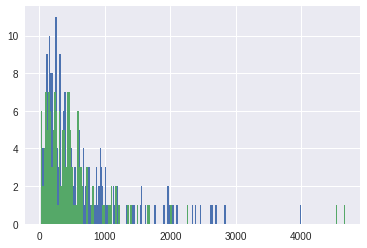

In [18]:
df[df.incoherence == 0].len.hist(bins=200)
df[df.incoherence == 1].len.hist(bins=200)

#### Token-length distribution

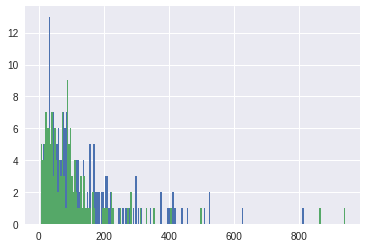

In [19]:
df[df.incoherence == 0].len_tok.hist(bins=200)
df[df.incoherence == 1].len_tok.hist(bins=200)

#### Language models (LM)

Run the cell below if the LM is not available (vector size = 100)

In [20]:
'''
#model100
#%%monitor_cell language_model_100

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

content_input = text_input_builder_bow(path) # list where each sentence is a string

new_input = [string.split() for string in content_input] # list where each sentence is a list

#input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, hs=1, negative=0)

#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
'''

"\n#model100\n#%%monitor_cell language_model_100\n\nlogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)\npath = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'\n\ncontent_input = text_input_builder_bow(path) # list where each sentence is a string\n\nnew_input = [string.split() for string in content_input] # list where each sentence is a list\n\n#input_sentences must be list of lists of tokens\n# https://rare-technologies.com/word2vec-tutorial/\nmodel = Word2Vec(new_input, hs=1, negative=0)\n\n#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')\n"

Load pre-defined model (vector size = 100)

In [21]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')

In [22]:
len(model.wv.vocab)

729651

Run the cell below if the LM is not available (vector size = 300)

In [23]:
'''
#model300
#%%monitor_cell language_model_300

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

content_input = text_input_builder_bow(path) # list where each sentence is a string

new_input = [string.split() for string in content_input] # list where each sentence is a list

# input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, size=300, hs=1, negative=0)

#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
'''

"\n#model300\n#%%monitor_cell language_model_300\n\nlogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)\npath = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'\n\ncontent_input = text_input_builder_bow(path) # list where each sentence is a string\n\nnew_input = [string.split() for string in content_input] # list where each sentence is a list\n\n# input_sentences must be list of lists of tokens\n# https://rare-technologies.com/word2vec-tutorial/\nmodel = Word2Vec(new_input, size=300, hs=1, negative=0)\n\n#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')\n"

Load pre-defined model (vector size = 300)

In [24]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')

#### Compute LM scores

In [25]:
df['score'] = 'NaN'
for row in range(0, df.shape[0]):
    s = df.loc[row,'string']
    df.loc[row, 'score'] = model.score([re.findall(string_pattern, s.strip().lower())])[0]
    df.loc[row, 'prob'] = np.exp(df.loc[row, 'score'])

In [26]:
df.describe()

,index,id,id_modif,parentid,user_id,incoherence,len,len_tok,prob
count,355.000000,3.550000e+02,3.550000e+02,3.550000e+02,2.100000e+02,355.000000,355.000000,355.000000,3.550000e+02
mean,979.270423,6.503335e+07,7.723672e+05,6.430306e+07,4.920554e+05,0.402817,581.273239,117.625352,9.469822e-17
std,579.442802,3.638354e+07,4.246841e+05,3.609245e+07,5.084550e+05,0.491157,629.489531,126.219153,1.557507e-15
min,0.000000,1.366927e+06,8.500000e+02,1.336409e+06,3.260000e+02,0.000000,22.000000,6.000000,0.000000e+00
25%,444.500000,3.602816e+07,4.284465e+05,3.564832e+07,1.204830e+05,0.000000,199.500000,40.000000,0.000000e+00
50%,1028.000000,6.014793e+07,7.735620e+05,5.883866e+07,3.264895e+05,0.000000,395.000000,80.000000,0.000000e+00
75%,1512.000000,9.322159e+07,1.130942e+06,9.137724e+07,7.015215e+05,1.000000,711.500000,144.000000,0.000000e+00
max,1894.000000,1.388645e+08,2.589875e+06,1.388645e+08,2.609867e+06,1.000000,4665.000000,942.000000,2.912112e-14


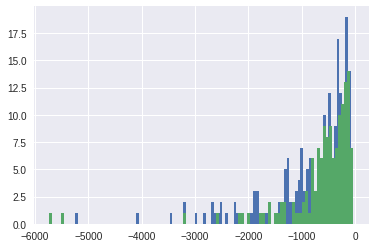

In [28]:
df[df["incoherence"]==0].score.hist(bins=100)
df[df["incoherence"]==1].score.hist(bins=100)

## Split train/test 

In [30]:
df_train = df.sample(frac=0.8)#,random_state=42)
df_test = df.drop(df_train.index).copy()
df_train = df_train.reset_index(drop=True).copy()
df_test = df_test.reset_index(drop=True).copy()
df_train = df_train.fillna('')
df_test = df_test.fillna('')

print('Distribution of labels in TRAIN set')
df_train.incoherence.value_counts()
df_train.incoherence.value_counts(normalize=True)
print('\n')
print('Distribution of labels in TEST set')
df_test.incoherence.value_counts()
df_test.incoherence.value_counts(normalize=True)

Distribution of labels in TRAIN set


0    167
1    117
Name: incoherence, dtype: int64

0    0.588028
1    0.411972
Name: incoherence, dtype: float64



Distribution of labels in TEST set


0    45
1    26
Name: incoherence, dtype: int64

0    0.633803
1    0.366197
Name: incoherence, dtype: float64

In [31]:
df_train.shape
df_test.shape

(284, 39)

(71, 39)

#### Functions

Choose either <code>cv_SKF</code>, <code>cv_RSKF</code> or <code>cv_LPO</code> for cross-validation setting.

In [32]:
cv_SKF = StratifiedKFold(n_splits=6, shuffle=True)
cv_RSKF = RepeatedStratifiedKFold(n_splits=6)
cv_LPO = LeavePOut(1)


def cross_val_series(X, y, clf, cv_input):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc'] #, 'neg_log_loss'
    df_scores = pd.DataFrame(index=metrics_list, columns=['score'])
    
    for metric in metrics_list:
        df_scores.loc[metric,'score'] = '{:.3f} (+/- {:.3f})'.format(cross_val_score(clf, X, y, cv=cv_input, scoring=metric).mean(), 1.96 * cross_val_score(clf, X, y, cv=cv_input, scoring=metric).std() / np.sqrt(len(cross_val_score(clf, X, y, cv=cv_input, scoring=metric))))
    return df_scores

Testing function.

In [33]:
def model_testing(X_train, y_train, X_test, y_test, model):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc']
    df_scores_test = pd.DataFrame(index=metrics_list, columns=['test_score'])
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    y_pred_proba = model.predict_proba(X_test)
    
    
    df_scores_test.loc['precision', 'test_score'] = '{:.3f}'.format(precision_score(y_test, y_pred))
    df_scores_test.loc['recall', 'test_score'] = '{:.3f}'.format(recall_score(y_test, y_pred))
    df_scores_test.loc['f1', 'test_score'] = '{:.3f}'.format(f1_score(y_test, y_pred))
    df_scores_test.loc['roc_auc', 'test_score'] = '{:.3f}'.format(roc_auc_score(y_test, y_pred_proba[:,1]))
    
    full_test_df = df_test.copy()
    full_test_df['y_test'] = pd.DataFrame(y_test)
    full_test_df['y_pred'] = pd.DataFrame(y_pred)
    full_test_df['y_pred_proba'] = pd.DataFrame(y_pred_proba[:,1])
    
    return df_scores_test, full_test_df, y_test, y_pred, y_pred_proba

Plot ROC curve.

In [34]:
def plot_roc_auc(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Method 1: BOW

Build new model (cell below) or load pre-existing model (next cell below)

In [134]:
%%time
#path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'
#txt_input = text_input_builder_bow(path)
#vectorizer = CountVectorizer(max_features=4096)
#vectorizer.fit(txt_input)
##pickle.dump(vectorizer, open("vectorizer_bow.p", "wb"))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.34 µs


In [135]:
vectorizer = pickle.load(open( "/home/dp/notebooks/vectorizer_bow.p", "rb" ))

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [136]:
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_))) # max = 2,431,546

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values.copy()
y_test = df_test.incoherence.values.copy()

Voc length: 4,096


#### Dummy classifier

In [137]:
clf = DummyClassifier(strategy='uniform')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

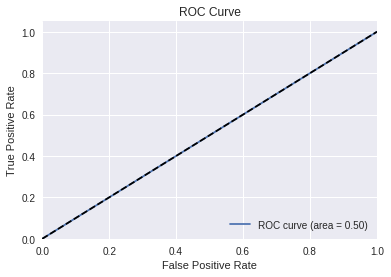

,score
precision,0.438 (+/- 0.069)
recall,0.507 (+/- 0.098)
f1,0.434 (+/- 0.055)
roc_auc,0.500 (+/- 0.000)


,test_score
precision,0.400
recall,0.538
f1,0.459
roc_auc,0.500


In [138]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

#### Logistic Regression classifier (best performance with string L2 regularization)

In [139]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.0000001)#, max_iter = 1000)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: Th

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The ma

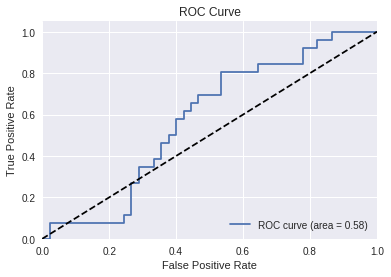

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.537 (+/- 0.075)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.578


In [140]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [141]:
logreg_bow_df = full_test_df.copy()

0    26
Name: y_pred, dtype: int64

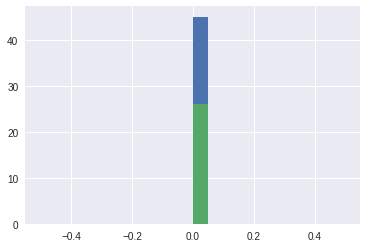

In [142]:
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

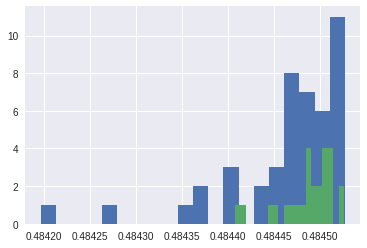

In [143]:
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred_proba.hist(bins=20)

In [144]:
logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg_bow_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg_bow_df.loc[i,'string'],'\n')
    
for id_subset in logreg_bow_df.sample_id[(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
9,hitman: contracts est un jeu vidéo,1,1,0,0.484526,36.0,7.0
6,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.484525,117.0,23.0
18,la circonscription de merto lemariam est une...,1,1,0,0.484512,198.0,34.0
22,gabriel pontello est un acteur italien de fi...,1,1,0,0.484510,159.0,30.0
24,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.484510,187.0,43.0
16,les nuits rouges du bourreau de jade est un ...,1,1,0,0.484509,164.0,32.0
12,le grand bisse de vex est un bisse valaisan ...,1,1,0,0.484508,103.0,22.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.484506,238.0,42.0
14,de nombreux artistes importants ont participé ...,1,1,0,0.484506,1049.0,207.0
23,cette plante originaire du sud-ouest des états...,1,1,0,0.484502,382.0,74.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision Tree classifier

In [145]:
clf = DecisionTreeClassifier()#criterion='entropy', splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

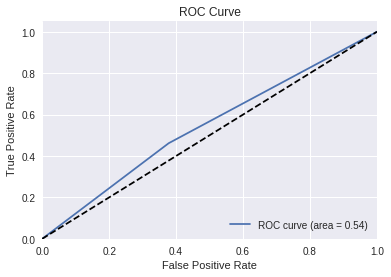

,score
precision,0.358 (+/- 0.082)
recall,0.334 (+/- 0.066)
f1,0.361 (+/- 0.042)
roc_auc,0.464 (+/- 0.046)


,test_score
precision,0.414
recall,0.462
f1,0.436
roc_auc,0.542


In [146]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [147]:
dt_bow_df = full_test_df.copy()

0    14
1    12
Name: y_pred, dtype: int64

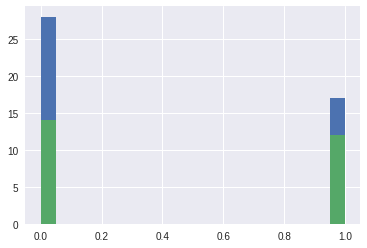

In [148]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

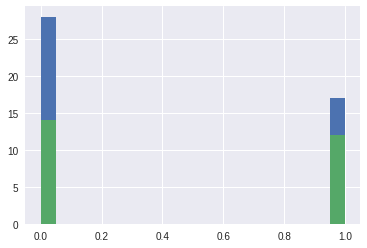

In [149]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred_proba.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [150]:
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_bow_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(dt_bow_df.loc[i,'string'],'\n')
    
for id_subset in dt_bow_df.sample_id[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,elle est le point culminant de la liturgie chr...,1,1,0,0.0,273.0,52.0
17,l'empereur constance ii avait fait enlever du ...,1,1,0,0.0,1096.0,224.0
15,"marth est une princesse de taille normale, ell...",1,1,0,0.0,413.0,88.0
24,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.0,187.0,43.0
11,créée en opposition à la loi du 23 février 200...,1,1,0,0.0,405.0,80.0
10,"michael, chris, izzy, kenny et marc sont amis ...",1,1,0,0.0,500.0,115.0
8,weymouth football club (également connu sous...,1,1,0,0.0,461.0,88.0
25,"en 1675, elle devint possession de hans willem...",1,1,0,0.0,823.0,169.0
6,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.0,117.0,23.0
4,"cette institution, premier lycée de filles par...",1,1,0,0.0,655.0,129.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
5,elle a fait ses études primaires et secondaire...,1,1,1,1.0,376.0,76.0
9,hitman: contracts est un jeu vidéo,1,1,1,1.0,36.0,7.0
12,le grand bisse de vex est un bisse valaisan ...,1,1,1,1.0,103.0,22.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,1.0,220.0,45.0
14,de nombreux artistes importants ont participé ...,1,1,1,1.0,1049.0,207.0
16,les nuits rouges du bourreau de jade est un ...,1,1,1,1.0,164.0,32.0
18,la circonscription de merto lemariam est une...,1,1,1,1.0,198.0,34.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,1,1.0,238.0,42.0
20,le chef des gardes-serpents entre dans une piè...,1,1,1,1.0,372.0,92.0
21,"basée à copenhague, elle opère cinq chaînes de...",1,1,1,1.0,722.0,150.0


elle a fait ses études primaires et secondaires au koweït puis a obtenu un diplôme, le "bachelor’s degree in business administration" en 1991 à l'université américaine du caire, en égypte, puis un diplôme d'études approfondies en gestion d'entreprise de l'hec genève, en suisse. elle est connue pour son implication dans la défense des enfants victimes de violences et d'abus. 

 hitman: contracts  est un jeu vidéo 

le  grand bisse de vex  est un bisse valaisan de 12 kilomètres de long situé dans le district d'hérens. 

aux municipales de 1995, à l'instigation de laurent fabius, il est le cadidat socialiste à rouen et emporte la mairie au dauphin de jean lecanuet, françois gautier.  il est également professeur associé à l'ipag de rouen. 

de nombreux artistes importants ont participé depuis près de 50 ans à la biennale de paris : marina abramovic, vito acconci, karen andreassian, le collectif au travail/at work, john m. armleder, joseph beuys, gary bigot, alighiero boetti, microcollectio

Mean length of accurately detected positive scores (character-wise and token-wise)

In [151]:
dt_bow_df.len[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()
dt_bow_df.len_tok[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()

334.9166666666667

67.58333333333333

## Method 2: TF-IDF

In [159]:
%%time
#vectorizer = TfidfVectorizer(max_features=4096)
#vectorizer.fit(txt_input)
##pickle.dump(vectorizer, open("vectorizer_tfidf.p", "wb"))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.34 µs


In [160]:
vectorizer = pickle.load(open("/home/dp/notebooks/vectorizer_tfidf.p", "rb"))

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [161]:
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_)))

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values
y_test = df_test.incoherence.values

Voc length: 4,096


#### Logistic Regression classifier

In [162]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.0000001) #,  The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: Th

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The ma

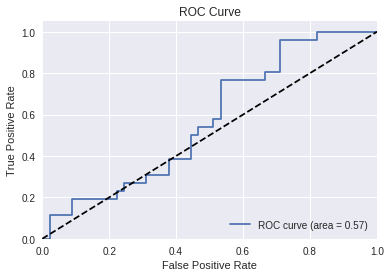

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.549 (+/- 0.054)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.574


In [163]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [164]:
logreg_tfidf_df = full_test_df.copy()

0    26
Name: y_pred, dtype: int64

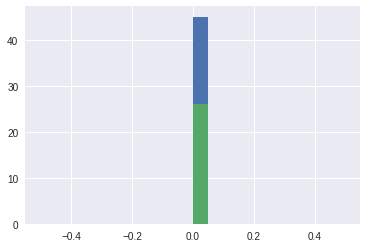

In [165]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

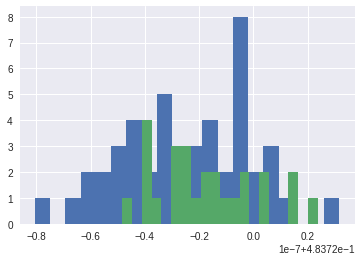

In [166]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [167]:
logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg_tfidf_df.loc[i,'string'],'\n')
    
for id_subset in logreg_tfidf_df.sample_id[(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
6,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.48372,117.0,23.0
14,de nombreux artistes importants ont participé ...,1,1,0,0.48372,1049.0,207.0
9,hitman: contracts est un jeu vidéo,1,1,0,0.48372,36.0,7.0
22,gabriel pontello est un acteur italien de fi...,1,1,0,0.48372,159.0,30.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.48372,238.0,42.0
16,les nuits rouges du bourreau de jade est un ...,1,1,0,0.48372,164.0,32.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,0,0.48372,220.0,45.0
1,il est classé seizième meilleur film de tous l...,1,1,0,0.48372,220.0,54.0
21,"basée à copenhague, elle opère cinq chaînes de...",1,1,0,0.48372,722.0,150.0
18,la circonscription de merto lemariam est une...,1,1,0,0.48372,198.0,34.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


Mean length of detected positive scores (character-wise and token-wise)

In [168]:
logreg_tfidf_df.len[(dt_bow_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].mean()
logreg_tfidf_df.len_tok[(dt_bow_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].mean()

nan

nan

#### Decision tree classifier

In [169]:
clf = DecisionTreeClassifier()#criterion='entropy', splitter='random')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

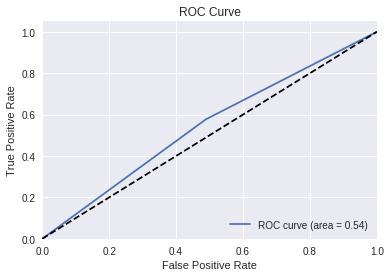

,score
precision,0.434 (+/- 0.063)
recall,0.402 (+/- 0.069)
f1,0.484 (+/- 0.112)
roc_auc,0.550 (+/- 0.033)


,test_score
precision,0.405
recall,0.577
f1,0.476
roc_auc,0.544


In [170]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [171]:
dt_tfidf_df = full_test_df.copy()

1    15
0    11
Name: y_pred, dtype: int64

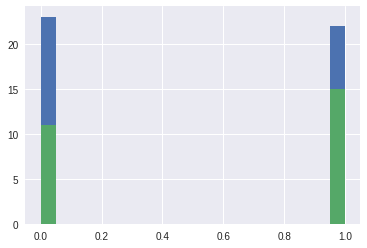

In [172]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

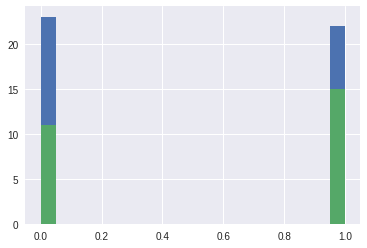

In [173]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred_proba.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [174]:
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(dt_tfidf_df.loc[i,'string'],'\n')
    
for id_subset in dt_tfidf_df.sample_id[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,1.0,220.0,45.0
9,hitman: contracts est un jeu vidéo,1,1,1,1.0,36.0,7.0
24,orleans est un comté au nord-ouest de l'état d...,1,1,1,1.0,187.0,43.0
21,"basée à copenhague, elle opère cinq chaînes de...",1,1,1,1.0,722.0,150.0
15,"marth est une princesse de taille normale, ell...",1,1,1,1.0,413.0,88.0
1,il est classé seizième meilleur film de tous l...,1,1,1,1.0,220.0,54.0
12,le grand bisse de vex est un bisse valaisan ...,1,1,1,1.0,103.0,22.0
11,créée en opposition à la loi du 23 février 200...,1,1,1,1.0,405.0,80.0
10,"michael, chris, izzy, kenny et marc sont amis ...",1,1,1,1.0,500.0,115.0
25,"en 1675, elle devint possession de hans willem...",1,1,1,1.0,823.0,169.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
1,il est classé seizième meilleur film de tous l...,1,1,1,1.0,220.0,54.0
2,"le 9 mai 2013, munky a annoncé dans une interv...",1,1,1,1.0,1485.0,312.0
3,"en septembre 2005, pour relancer les faibles v...",1,1,1,1.0,531.0,96.0
4,"cette institution, premier lycée de filles par...",1,1,1,1.0,655.0,129.0
5,elle a fait ses études primaires et secondaire...,1,1,1,1.0,376.0,76.0
6,patrick cousot (né le 3 décembre 1948) est i...,1,1,1,1.0,117.0,23.0
9,hitman: contracts est un jeu vidéo,1,1,1,1.0,36.0,7.0
10,"michael, chris, izzy, kenny et marc sont amis ...",1,1,1,1.0,500.0,115.0
11,créée en opposition à la loi du 23 février 200...,1,1,1,1.0,405.0,80.0
12,le grand bisse de vex est un bisse valaisan ...,1,1,1,1.0,103.0,22.0


il est classé seizième meilleur film de tous les temps d'après le site de référence imdb avec une note de 8,7/10. l'institut du film américain l'a nommé 20e plus grand film américain de l'histoire en 1998 et 33e en 2007. 

le 9 mai 2013, munky a annoncé dans une interview avec artist direct que le groupe a écrit 25 chansons complètes et 15 d'entre eux seraient mis sur l'album.le 18 mai 2013, à une nouvelle entrevue avec kornrow, munky et head ont révélé un grand nombre de titres de chansons; parmi eux étaient "love and meth", "never never", "pray for me", et "victimized". head dit aussi soit "love and meth" ou "pray for me" sera premier single de l'album. le 1er juin 2013, caroline records ajoutés à leur liste korn confirmant que le groupe a été signé à un contrat avec la label, ils sont en partenariat avec la gestion prospect park. le 9 juin 2013, à un entretien avec puls, au rock im park, brian "head" welch a confirmé qu'à compter de cette date le nouvel album de korn a été complètem

Mean length of detected positive scores (character-wise and token-wise)

In [175]:
dt_tfidf_df.len[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()
dt_tfidf_df.len_tok[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()

452.8666666666667

93.93333333333334

## Method 3: Mean vectors

Function for getting mean vector of each string

In [176]:
def w2v_extractor(df, model):
    
    token_list = []
    sentence_list = []
    
    for i in range(0, df.shape[0]): # for each string
        g = 0
        for token in re.findall(string_pattern, df.loc[i,'string']): # for each token of the string
            g += 1
            if token in model.wv.vocab:
                token_list.append(np.reshape(model.wv.word_vec(token), (1, model.vector_size)))
                
            else:
                continue
        
        string_matrix = np.vstack(token_list)
        
        string_average = string_matrix.mean(axis=0)
        
        sentence_list.append(string_average)
        token_list = []
    
    string_ave_matrix = np.vstack(sentence_list)
    
    list_col = [] # generate columns labels for each of the dimensions
    for i in range(0, model.vector_size):
        list_col.append('dim_{}'.format(i))

    dim_df = pd.DataFrame(string_ave_matrix)
    dim_df.columns = list_col
    
    return dim_df

### 3.1 Vector size 100

In [177]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')

dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [178]:
clf = LogisticRegression(solver='sag', n_jobs=-1)#, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

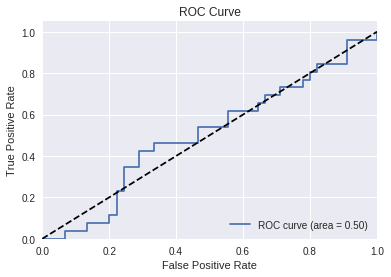

100

,score
precision,0.329 (+/- 0.056)
recall,0.196 (+/- 0.065)
f1,0.235 (+/- 0.099)
roc_auc,0.467 (+/- 0.034)


,test_score
precision,0.409
recall,0.346
f1,0.375
roc_auc,0.503


In [179]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [180]:
logreg100_mean_df = full_test_df.copy()

0    17
1     9
Name: y_pred, dtype: int64

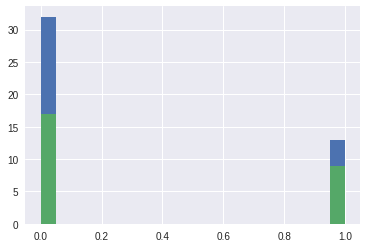

In [181]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

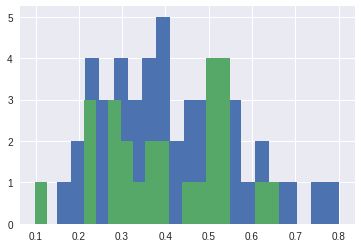

In [182]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [183]:
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg100_mean_df.loc[i,'string'],'\n')
    
for id_subset in logreg100_mean_df.sample_id[(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
17,l'empereur constance ii avait fait enlever du ...,1,1,1,0.662948,1096.0,224.0
9,hitman: contracts est un jeu vidéo,1,1,1,0.619805,36.0,7.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,0.549237,220.0,45.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,1,0.533562,238.0,42.0
4,"cette institution, premier lycée de filles par...",1,1,1,0.531114,655.0,129.0
16,les nuits rouges du bourreau de jade est un ...,1,1,1,0.530411,164.0,32.0
22,gabriel pontello est un acteur italien de fi...,1,1,1,0.520755,159.0,30.0
6,patrick cousot (né le 3 décembre 1948) est i...,1,1,1,0.518496,117.0,23.0
1,il est classé seizième meilleur film de tous l...,1,1,1,0.516522,220.0,54.0
7,les z 4900 et les z 4500 constituent la prem...,1,1,0,0.499068,362.0,73.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
17,l'empereur constance ii avait fait enlever du ...,1,1,1,0.662948,1096.0,224.0
9,hitman: contracts est un jeu vidéo,1,1,1,0.619805,36.0,7.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,0.549237,220.0,45.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,1,0.533562,238.0,42.0
4,"cette institution, premier lycée de filles par...",1,1,1,0.531114,655.0,129.0
16,les nuits rouges du bourreau de jade est un ...,1,1,1,0.530411,164.0,32.0
22,gabriel pontello est un acteur italien de fi...,1,1,1,0.520755,159.0,30.0
6,patrick cousot (né le 3 décembre 1948) est i...,1,1,1,0.518496,117.0,23.0
1,il est classé seizième meilleur film de tous l...,1,1,1,0.516522,220.0,54.0


l'empereur constance ii avait fait enlever du sénat l'autel de la victoire ; julien l'y replaça, gratien l'en retira définitivement. la victoire continue à figurer sur les monuments et les monnaies, purifiée par l'alliance avec le monogramme du christ. honorius et valentinien iii tiennent d'une main la victoire, de l'autre le  labarum .  victoria augustorum  se retrouve sur les monnaies du dernier empereur romain d'occident, romulus augustule. même sous justinien, semble-t-il, le symbole de la victoire reste lié à la personne de l'empereur. dépourvu de tout caractère cultuel, ce fétiche n'a cependant pas perdu toute signification religieuse. si la victoire n'est plus une divinité, on la considère comme un bienfait divin, comme la grâce suprême que l'empereur et les sujets de l'empire puissent demander à dieu devant les menaces de plus en plus redoutables de la barbarie. ainsi, par un singulier retour, elle se fond de nouveau au sein d'une divinité plus large et elle devient un attribut

#### Decision tree classifier

In [184]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

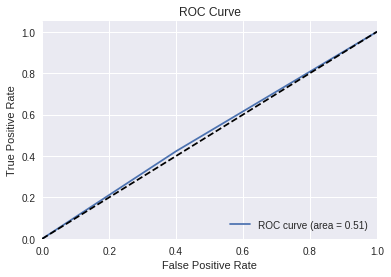

100

,score
precision,0.437 (+/- 0.096)
recall,0.453 (+/- 0.114)
f1,0.378 (+/- 0.051)
roc_auc,0.523 (+/- 0.076)


,test_score
precision,0.379
recall,0.423
f1,0.400
roc_auc,0.512


In [185]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [186]:
dt100_mean_df = full_test_df.copy()

0    15
1    11
Name: y_pred, dtype: int64

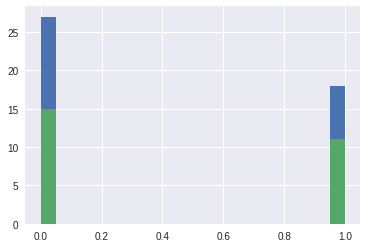

In [187]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

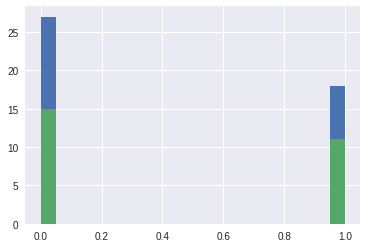

In [188]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [189]:
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(dt100_mean_df.loc[i,'string'],'\n')
    
for id_subset in dt100_mean_df.sample_id[(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
24,orleans est un comté au nord-ouest de l'état d...,1,1,1,1.0,187.0,43.0
3,"en septembre 2005, pour relancer les faibles v...",1,1,1,1.0,531.0,96.0
23,cette plante originaire du sud-ouest des états...,1,1,1,1.0,382.0,74.0
22,gabriel pontello est un acteur italien de fi...,1,1,1,1.0,159.0,30.0
7,les z 4900 et les z 4500 constituent la prem...,1,1,1,1.0,362.0,73.0
20,le chef des gardes-serpents entre dans une piè...,1,1,1,1.0,372.0,92.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,1,1.0,238.0,42.0
10,"michael, chris, izzy, kenny et marc sont amis ...",1,1,1,1.0,500.0,115.0
18,la circonscription de merto lemariam est une...,1,1,1,1.0,198.0,34.0
12,le grand bisse de vex est un bisse valaisan ...,1,1,1,1.0,103.0,22.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
1,il est classé seizième meilleur film de tous l...,1,1,1,1.0,220.0,54.0
3,"en septembre 2005, pour relancer les faibles v...",1,1,1,1.0,531.0,96.0
7,les z 4900 et les z 4500 constituent la prem...,1,1,1,1.0,362.0,73.0
10,"michael, chris, izzy, kenny et marc sont amis ...",1,1,1,1.0,500.0,115.0
12,le grand bisse de vex est un bisse valaisan ...,1,1,1,1.0,103.0,22.0
18,la circonscription de merto lemariam est une...,1,1,1,1.0,198.0,34.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,1,1.0,238.0,42.0
20,le chef des gardes-serpents entre dans une piè...,1,1,1,1.0,372.0,92.0
22,gabriel pontello est un acteur italien de fi...,1,1,1,1.0,159.0,30.0
23,cette plante originaire du sud-ouest des états...,1,1,1,1.0,382.0,74.0


il est classé seizième meilleur film de tous les temps d'après le site de référence imdb avec une note de 8,7/10. l'institut du film américain l'a nommé 20e plus grand film américain de l'histoire en 1998 et 33e en 2007. 

en septembre 2005, pour relancer les faibles ventes de la console, tiger telematics annonce un  gizmondo widescreen  avec un écran 16/9. ce modèle ne sera jamais commercialisé : la branche européenne en charge de la commercialisation,  gizmondo europe  est placée en liquidation judiciaire en janvier 2006. mais carl freer relance la gizmondo v2 en mai 2008 et une version  widescreen pour noël 2008. avec de nouvelles fonctions et surtout le marché gizmondo live. donc il s'agit du relancement de la gizmondo sans stefan eriksson. 

les  z 4900  et les z 4500 constituent la première série de 30 automotrices électriques e abd 1 à 30 de la compagnie du midi. elles se caractérisent par leur courant d'alimentation unique en france, alternatif  12 kv  monophasé, à la fréquence

### 3.2 Vector size 300

In [190]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')

dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [191]:
clf = LogisticRegression(solver='sag', n_jobs=-1)#, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


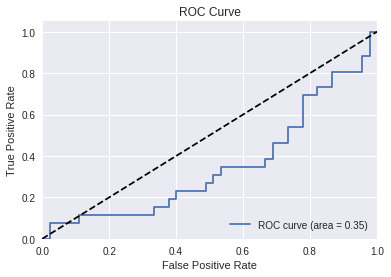

300

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.449 (+/- 0.048)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.353


In [192]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [193]:
logreg300_mean_df = full_test_df.copy()

0    26
Name: y_pred, dtype: int64

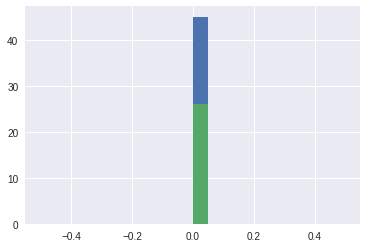

In [194]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

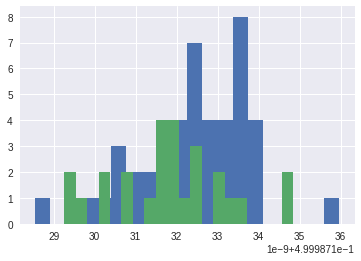

In [195]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [196]:
logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg300_mean_df.loc[i,'string'],'\n')
    
for id_subset in logreg300_mean_df.sample_id[(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
12,le grand bisse de vex est un bisse valaisan ...,1,1,0,0.499987,103.0,22.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.499987,238.0,42.0
5,elle a fait ses études primaires et secondaire...,1,1,0,0.499987,376.0,76.0
22,gabriel pontello est un acteur italien de fi...,1,1,0,0.499987,159.0,30.0
6,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.499987,117.0,23.0
11,créée en opposition à la loi du 23 février 200...,1,1,0,0.499987,405.0,80.0
1,il est classé seizième meilleur film de tous l...,1,1,0,0.499987,220.0,54.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,0,0.499987,220.0,45.0
2,"le 9 mai 2013, munky a annoncé dans une interv...",1,1,0,0.499987,1485.0,312.0
20,le chef des gardes-serpents entre dans une piè...,1,1,0,0.499987,372.0,92.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision Tree classifier

In [197]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

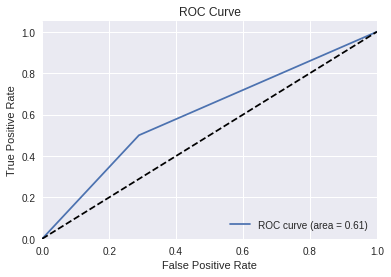

300

,score
precision,0.481 (+/- 0.059)
recall,0.477 (+/- 0.080)
f1,0.491 (+/- 0.094)
roc_auc,0.503 (+/- 0.043)


,test_score
precision,0.500
recall,0.500
f1,0.500
roc_auc,0.606


In [198]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [199]:
dt300_mean_df = full_test_df.copy()

1    13
0    13
Name: y_pred, dtype: int64

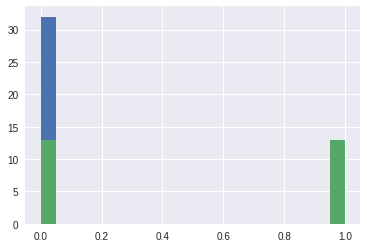

In [200]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

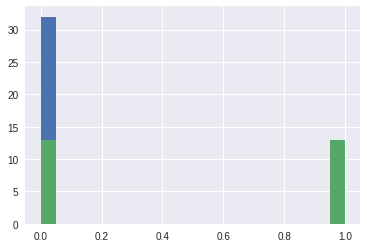

In [201]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [202]:
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(dt300_mean_df.loc[i,'string'],'\n')
    
for id_subset in dt300_mean_df.sample_id[(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
12,le grand bisse de vex est un bisse valaisan ...,1,1,0,0.0,103.0,22.0
22,gabriel pontello est un acteur italien de fi...,1,1,0,0.0,159.0,30.0
20,le chef des gardes-serpents entre dans une piè...,1,1,0,0.0,372.0,92.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.0,238.0,42.0
15,"marth est une princesse de taille normale, ell...",1,1,0,0.0,413.0,88.0
24,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.0,187.0,43.0
11,créée en opposition à la loi du 23 février 200...,1,1,0,0.0,405.0,80.0
10,"michael, chris, izzy, kenny et marc sont amis ...",1,1,0,0.0,500.0,115.0
9,hitman: contracts est un jeu vidéo,1,1,0,0.0,36.0,7.0
25,"en 1675, elle devint possession de hans willem...",1,1,0,0.0,823.0,169.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,elle est le point culminant de la liturgie chr...,1,1,1,1.0,273.0,52.0
1,il est classé seizième meilleur film de tous l...,1,1,1,1.0,220.0,54.0
3,"en septembre 2005, pour relancer les faibles v...",1,1,1,1.0,531.0,96.0
4,"cette institution, premier lycée de filles par...",1,1,1,1.0,655.0,129.0
6,patrick cousot (né le 3 décembre 1948) est i...,1,1,1,1.0,117.0,23.0
7,les z 4900 et les z 4500 constituent la prem...,1,1,1,1.0,362.0,73.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,1.0,220.0,45.0
14,de nombreux artistes importants ont participé ...,1,1,1,1.0,1049.0,207.0
16,les nuits rouges du bourreau de jade est un ...,1,1,1,1.0,164.0,32.0
17,l'empereur constance ii avait fait enlever du ...,1,1,1,1.0,1096.0,224.0


elle est le point culminant de la liturgie chrétienne. c'est avant tout la "répétition" du repas du  jeudi saint avec commémoration  de la mort et de la résurrection du christ.(cette commémoration donnant lieu à de graves conflits théologique quant à la valeur lui donner). 

il est classé seizième meilleur film de tous les temps d'après le site de référence imdb avec une note de 8,7/10. l'institut du film américain l'a nommé 20e plus grand film américain de l'histoire en 1998 et 33e en 2007. 

en septembre 2005, pour relancer les faibles ventes de la console, tiger telematics annonce un  gizmondo widescreen  avec un écran 16/9. ce modèle ne sera jamais commercialisé : la branche européenne en charge de la commercialisation,  gizmondo europe  est placée en liquidation judiciaire en janvier 2006. mais carl freer relance la gizmondo v2 en mai 2008 et une version  widescreen pour noël 2008. avec de nouvelles fonctions et surtout le marché gizmondo live. donc il s'agit du relancement de la 

## Method 4: skig-gram model

In [203]:
def scores_generator(df_train, df_test, pair_fn):
    
    df_test_temp = df_test.copy()
    df_test_temp = df_test_temp.reset_index()

    df_scores = pd.DataFrame(index=df_train.index, columns=['score'])
    df_scores_test = pd.DataFrame(index=df_test_temp.index, columns=['score'])

    for i in range(0, df_train.shape[0]):
        df_scores.loc[i,'string'] = df_train.loc[i,'string']
        df_scores.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_train.loc[i,'string']))
        
    X_train = df_scores.score
    y_train = df_train.incoherence
    
    for i in range(0, df_test_temp.shape[0]):
        df_scores_test.loc[i,'string'] = df_test_temp.loc[i,'string']
        df_scores_test.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_test_temp.loc[i,'string']))
        
    X_test = df_scores_test.score
    y_test = df_test_temp.incoherence
    
    return df_scores, X_train, y_train, df_scores_test, X_test, y_test

In [204]:
def score_sentence_sg(score_sg_fn, model, sentence, work=None):
    """
    Obtain likelihood score for a single sentence in a fitted skip-gram representaion.

    The sentence is a list of Vocab objects (or None, when the corresponding
    word is not in the vocabulary). Called internally from `Word2Vec.score()`.

    This is the non-optimized, Python version. If you have cython installed, gensim
    will use the optimized version from word2vec_inner instead.
    
    """

    log_prob_sentence = 0.0
    if model.negative:
        raise RuntimeError("scoring is only available for HS=True")

    word_vocabs = [model.wv.vocab[w] for w in sentence if w in model.wv.vocab]
    for pos, word in enumerate(word_vocabs):
        if word is None:
            continue  # OOV word in the input sentence => skip

        # now go over all words from the window, predicting each one in turn
        start = max(0, pos - model.window)
        for pos2, word2 in enumerate(word_vocabs[start : pos + model.window + 1], start):
            # don't train on OOV words and on the `word` itself
            if word2 is not None and pos2 != pos:
                log_prob_sentence += score_sg_fn(model, word, word2)

    return log_prob_sentence


def score_sg_pair_original(model, word, word2):
    l1 = model.wv.syn0[word2.index]
    l2a = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size
    sgn = (-1.0)**word.code  # ch function, 0-> 1, 1 -> -1
    lprob = -np.log(1.0 + np.exp(-sgn*np.dot(l1, l2a.T)))
    return sum(lprob)

def score_sg_pair(model, word, word2):
    #print(word, word2)
    l1 = model.wv.syn0[word2.index]
    print('a >', word.point.shape, word.code.shape)
    l2 = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size

    #assert l1.shape == l2.shape
    lprob = l2 * l1
    print('b >', lprob.shape)
    return lprob

### 4.1 Vector size 100

In [205]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


#### Logistic regression

In [206]:
clf = LogisticRegression()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

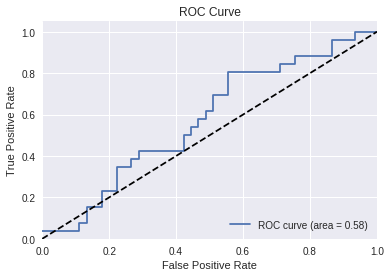

100

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.562 (+/- 0.048)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.576


In [207]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [208]:
logreg100_sg_df = full_test_df.copy()

0    26
Name: y_pred, dtype: int64

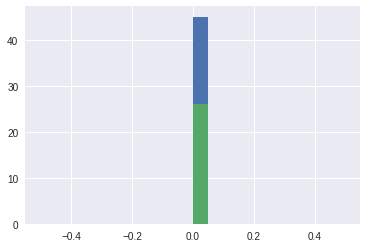

In [209]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

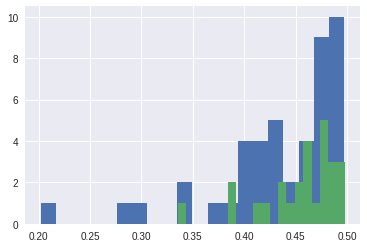

In [210]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [211]:
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_sg_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(logreg100_sg_df.loc[i,'string'],'\n')
    
for id_subset in logreg100_sg_df.sample_id[(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,"le 9 mai 2013, munky a annoncé dans une interv...",1,1,0,0.335236,1485.0,312.0
14,de nombreux artistes importants ont participé ...,1,1,0,0.385075,1049.0,207.0
17,l'empereur constance ii avait fait enlever du ...,1,1,0,0.385307,1096.0,224.0
25,"en 1675, elle devint possession de hans willem...",1,1,0,0.411593,823.0,169.0
21,"basée à copenhague, elle opère cinq chaînes de...",1,1,0,0.419855,722.0,150.0
4,"cette institution, premier lycée de filles par...",1,1,0,0.434383,655.0,129.0
10,"michael, chris, izzy, kenny et marc sont amis ...",1,1,0,0.440575,500.0,115.0
3,"en septembre 2005, pour relancer les faibles v...",1,1,0,0.443729,531.0,96.0
8,weymouth football club (également connu sous...,1,1,0,0.453301,461.0,88.0
15,"marth est une princesse de taille normale, ell...",1,1,0,0.456002,413.0,88.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision tree classifier

In [212]:
clf = DecisionTreeClassifier(max_depth=1)#,criterion='entropy')#, splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

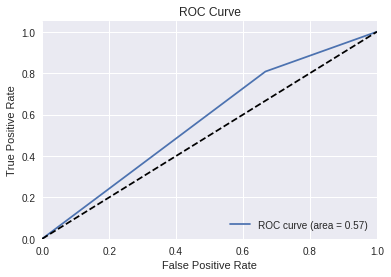

100

,score
precision,0.083 (+/- 0.295)
recall,0.000 (+/- 0.015)
f1,0.000 (+/- 0.027)
roc_auc,0.573 (+/- 0.039)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.571


In [213]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [214]:
dt100_sg_df = full_test_df.copy()

0    26
Name: y_pred, dtype: int64

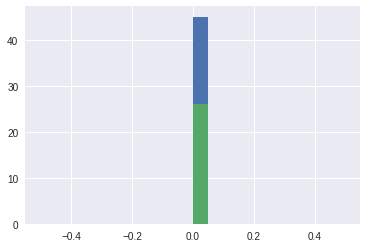

In [215]:
dt100_sg_df[dt100_sg_df.y_test == 0].y_pred.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

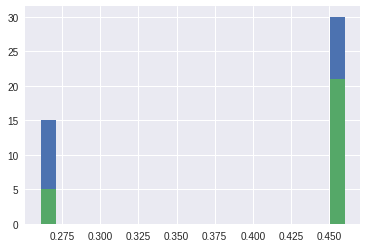

In [216]:
dt100_sg_df[dt100_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [217]:
dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(dt100_sg_df.loc[i,'string'],'\n')
    
for id_subset in dt100_sg_df.sample_id[(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,elle est le point culminant de la liturgie chr...,1,1,0,0.460465,273.0,52.0
12,le grand bisse de vex est un bisse valaisan ...,1,1,0,0.460465,103.0,22.0
24,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.460465,187.0,43.0
23,cette plante originaire du sud-ouest des états...,1,1,0,0.460465,382.0,74.0
22,gabriel pontello est un acteur italien de fi...,1,1,0,0.460465,159.0,30.0
20,le chef des gardes-serpents entre dans une piè...,1,1,0,0.460465,372.0,92.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.460465,238.0,42.0
18,la circonscription de merto lemariam est une...,1,1,0,0.460465,198.0,34.0
16,les nuits rouges du bourreau de jade est un ...,1,1,0,0.460465,164.0,32.0
15,"marth est une princesse de taille normale, ell...",1,1,0,0.460465,413.0,88.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


### 4.2 Vector size 300

In [218]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


#### Logistic regression

In [219]:
clf = LogisticRegression()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

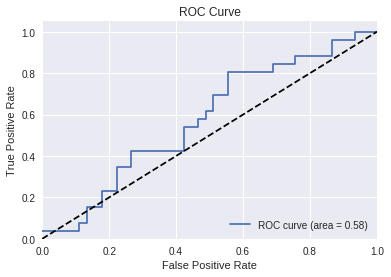

300

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.553 (+/- 0.050)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.579


In [220]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [221]:
logreg300_sg_df = full_test_df.copy()

0    26
Name: y_pred, dtype: int64

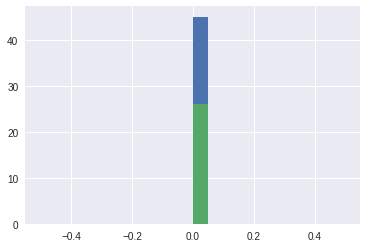

In [222]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

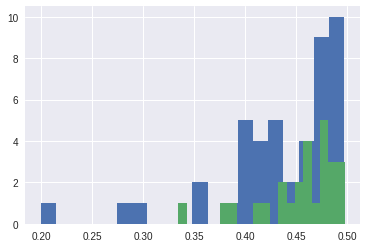

In [223]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [224]:
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(logreg300_sg_df.loc[i,'string'],'\n')
    
for id_subset in logreg300_sg_df.sample_id[(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
9,hitman: contracts est un jeu vidéo,1,1,0,0.497990,36.0,7.0
6,patrick cousot (né le 3 décembre 1948) est i...,1,1,0,0.491174,117.0,23.0
12,le grand bisse de vex est un bisse valaisan ...,1,1,0,0.490031,103.0,22.0
22,gabriel pontello est un acteur italien de fi...,1,1,0,0.486881,159.0,30.0
18,la circonscription de merto lemariam est une...,1,1,0,0.486099,198.0,34.0
16,les nuits rouges du bourreau de jade est un ...,1,1,0,0.484432,164.0,32.0
24,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.481074,187.0,43.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,0,0.480372,220.0,45.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.480084,238.0,42.0
1,il est classé seizième meilleur film de tous l...,1,1,0,0.475406,220.0,54.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision tree

In [225]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

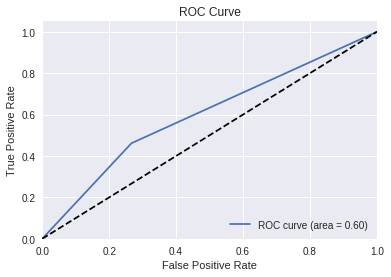

300

,score
precision,0.517 (+/- 0.041)
recall,0.548 (+/- 0.071)
f1,0.494 (+/- 0.096)
roc_auc,0.606 (+/- 0.043)


,test_score
precision,0.500
recall,0.462
f1,0.480
roc_auc,0.597


In [226]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [227]:
dt300_sg_df = full_test_df.copy()

0    14
1    12
Name: y_pred, dtype: int64

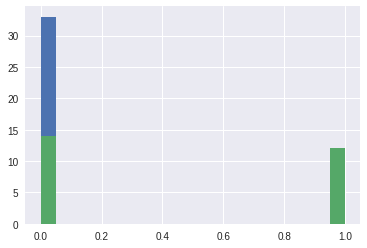

In [228]:
dt300_sg_df[dt300_sg_df.y_test == 0].y_pred.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

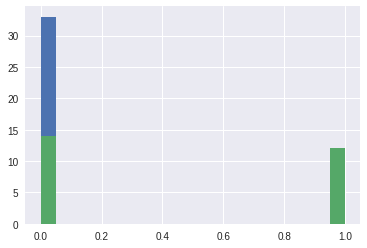

In [229]:
dt300_sg_df[dt300_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [230]:
dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(dt300_sg_df.loc[i,'string'],'\n')

for id_subset in dt300_sg_df.sample_id[(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,elle est le point culminant de la liturgie chr...,1,1,1,1.0,273.0,52.0
8,weymouth football club (également connu sous...,1,1,1,1.0,461.0,88.0
22,gabriel pontello est un acteur italien de fi...,1,1,1,1.0,159.0,30.0
20,le chef des gardes-serpents entre dans une piè...,1,1,1,1.0,372.0,92.0
17,l'empereur constance ii avait fait enlever du ...,1,1,1,1.0,1096.0,224.0
16,les nuits rouges du bourreau de jade est un ...,1,1,1,1.0,164.0,32.0
11,créée en opposition à la loi du 23 février 200...,1,1,1,1.0,405.0,80.0
10,"michael, chris, izzy, kenny et marc sont amis ...",1,1,1,1.0,500.0,115.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,1.0,220.0,45.0
4,"cette institution, premier lycée de filles par...",1,1,1,1.0,655.0,129.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,elle est le point culminant de la liturgie chr...,1,1,1,1.0,273.0,52.0
2,"le 9 mai 2013, munky a annoncé dans une interv...",1,1,1,1.0,1485.0,312.0
3,"en septembre 2005, pour relancer les faibles v...",1,1,1,1.0,531.0,96.0
4,"cette institution, premier lycée de filles par...",1,1,1,1.0,655.0,129.0
8,weymouth football club (également connu sous...,1,1,1,1.0,461.0,88.0
10,"michael, chris, izzy, kenny et marc sont amis ...",1,1,1,1.0,500.0,115.0
11,créée en opposition à la loi du 23 février 200...,1,1,1,1.0,405.0,80.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,1.0,220.0,45.0
16,les nuits rouges du bourreau de jade est un ...,1,1,1,1.0,164.0,32.0
17,l'empereur constance ii avait fait enlever du ...,1,1,1,1.0,1096.0,224.0


elle est le point culminant de la liturgie chrétienne. c'est avant tout la "répétition" du repas du  jeudi saint avec commémoration  de la mort et de la résurrection du christ.(cette commémoration donnant lieu à de graves conflits théologique quant à la valeur lui donner). 

le 9 mai 2013, munky a annoncé dans une interview avec artist direct que le groupe a écrit 25 chansons complètes et 15 d'entre eux seraient mis sur l'album.le 18 mai 2013, à une nouvelle entrevue avec kornrow, munky et head ont révélé un grand nombre de titres de chansons; parmi eux étaient "love and meth", "never never", "pray for me", et "victimized". head dit aussi soit "love and meth" ou "pray for me" sera premier single de l'album. le 1er juin 2013, caroline records ajoutés à leur liste korn confirmant que le groupe a été signé à un contrat avec la label, ils sont en partenariat avec la gestion prospect park. le 9 juin 2013, à un entretien avec puls, au rock im park, brian "head" welch a confirmé qu'à compter 